# vectorized version of berger and rigoutsos 1991

method used by chombo for grid generation 

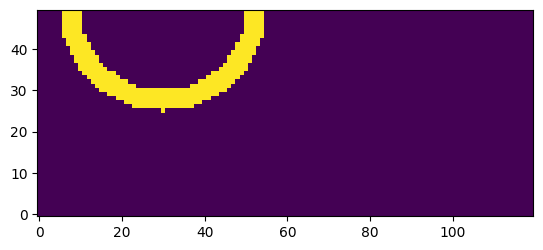

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 

Nx = 120
Ny = 50 

def getphi(ix, iy): 
    # generate an image mask 
    dist_min = 20
    dist_max = 25
    c = 50
    dist = np.sqrt((ix - 30)**2 +(iy - c)**2)
    mask = dist >= dist_min 
    return np.logical_and(mask, dist <= dist_max)
    
ix1d = np.arange(Nx)
iy1d = np.arange(Ny)
ix, iy = np.meshgrid(ix1d, iy1d)

phi = getphi(ix, iy)
plt.imshow(phi, origin='lower')

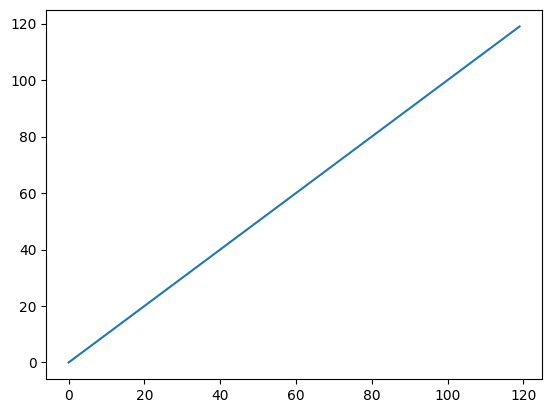

In [4]:
plt.plot(ix[0,:])

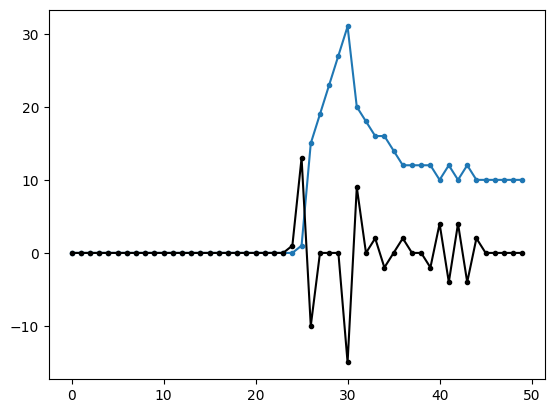

In [5]:
def get_sig_arrays(phi):
    # sig_x = np.ones((phi.shape[1],),dtype=int)
    sig_x = np.sum(phi, axis=1)
    # sig_y = np.ones((phi.shape[0],),dtype=int)
    sig_y = np.sum(phi, axis=0)
    return sig_x, sig_y 

def dsig2_dpx2(sig1d):    
    dsig1_dpx1 = sig1d[1:] - sig1d[:-1]
    dsig2_dpx2 = np.zeros(sig1d.shape)
    dsig2_dpx2[1:-1] = dsig1_dpx1[1:] - dsig1_dpx1[:-1]
    return dsig2_dpx2

    
sig_array_x, sig_array_y = get_sig_arrays(phi)
sig_array_x_second_derive = dsig2_dpx2(sig_array_x)
plt.plot(sig_array_x,marker='.')
plt.plot(sig_array_x_second_derive,'k', marker='.')


(50,)


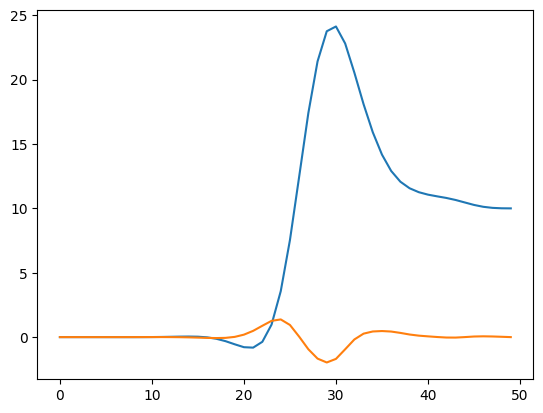

In [18]:
from scipy.signal import butter,filtfilt


def butter_lowpass_filter(data, cutoff, fs, order):
    Wn = 0.1 # critcal frequency, Hz
    fs = 1 # sample rate, Hz
    b, a = butter(order, Wn=Wn, btype='low', analog=False,fs =fs)
    y = filtfilt(b, a, data)
    return y

filtered = butter_lowpass_filter(sig_array_x, cutoff, fs, 2)
print(filtered.shape)
plt.plot(filtered)
filtered_d2 = dsig2_dpx2(filtered)
plt.plot(filtered_d2)

In [7]:
# filtered_d2.astype(int)


In [48]:
class grid_bounds:
    def __init__(self, le, re):
        self.le = np.asarray(le) 
        self.re = np.asarray(re)
        self.size = re - le

    def plot(self, ax, **kwargs):
        from matplotlib.patches import Rectangle
        width = self.re[1] - self.le[1]
        height = self.re[0] - self.le[0]
        rect = Rectangle(self.le, width , height, **kwargs)

        ax.add_patch(rect)

In [49]:
def find_max_change(f_d2_d2, f):
    signs = np.sign(f_d2_d2)
    
    sign_changes = np.where(signs[:-2] != signs[1:-1])[0] + 1    
    mag_change = f_d2_d2[sign_changes+1] - f_d2_d2[sign_changes]
    max_coord = sign_changes[np.max(mag_change) == mag_change]
    coord = max_coord[0]
    offset = - 2 * np.sign(f[coord+1] - f[coord])    
    coord = int(coord + offset)  # offset 1 extra depending on sign
    if coord < 0: 
        coord = 0
    elif coord == filtered.size:
        coord = filtered.size
    return coord
    
def find_grid_division_coord(phi, grid):
    phi_subset = phi[grid.le[1]:grid.re[1], grid.le[0]:grid.re[0]]
    sig_array_x, sig_array_y = get_sig_arrays(phi_subset)

    # print(split_xy)
    if len(sig_array_x) >= 10:
        filtered_x = butter_lowpass_filter(sig_array_x, cutoff, fs, 2)
        dx2d2 = dsig2_dpx2(filtered_x)    
        x_coord = find_max_change(dx2d2, filtered_x)
        x_coord = x_coord + grid.le[0]    
    else: 
        x_coord = None 

    if len(sig_array_y) >= 10:
        filtered_y = butter_lowpass_filter(sig_array_y, cutoff, fs, 2)    
        dy2d2 = dsig2_dpx2(filtered_y)                
        y_coord = find_max_change(dy2d2, filtered_y)
        y_coord = y_coord + grid.le[1]
    else:
        y_coord = None
    return x_coord, y_coord


In [22]:
def grid_filled_fraction(le, re, phi):
    grid_vals = phi[le[1]:re[1], le[0]:re[0]]
    return np.sum(grid_vals) / grid_vals.size
    
def grid_contains_points(le, re, phi):
    return np.any(phi[le[1]:re[1], le[0]:re[0]] > 0)



def split_grid_at_coord(grid, coord, phi):
    
    le = grid.le
    re = grid.re 

    new_grids = []

    if coord[0] is not None and coord[1] is not None:
        le0 = le 
        re0 = coord
        if grid_contains_points(le0, re0, phi):
            new_grids.append(grid_bounds(le0, re0))
    
        le1 = coord
        re1 = re
        if grid_contains_points(le1, re1, phi):
            new_grids.append(grid_bounds(le1, re1))
            
        le2 = np.array([coord[0], le[1]])
        re2 = np.array([re[0], coord[1]])
        if grid_contains_points(le2, re2, phi):
            new_grids.append(grid_bounds(le2, re2))
    
        le3 = np.array([le[0], coord[1]])
        re3 = np.array([coord[0], re[1]])
        if grid_contains_points(le3, re3, phi):
            new_grids.append(grid_bounds(le3, re3))

    elif coord[0] is None:
        # only split in y
        le0 = le
        re0 = (re[0], coord[1])
        if grid_contains_points(le0, re0, phi):
            new_grids.append(grid_bounds(le0, re0))

        le1 = (le[0], coord[1])
        re1 = re
        if grid_contains_points(le1, re1, phi):
            new_grids.append(grid_bounds(le1, re1))

    elif coord[1] is None:
        # only split in x
        le0 = le
        re0 = (coord[0], re[1])
        if grid_contains_points(le0, re0, phi):
            new_grids.append(grid_bounds(le0, re0))

        le1 = (coord[0], le[1])
        re1 = re
        if grid_contains_points(le1, re1, phi):
            new_grids.append(grid_bounds(le1, re1))

    return new_grids

In [23]:
grids = []
grids.append(grid_bounds(np.array([0,0]), np.array([Nx, Ny])))
coords = find_grid_division_coord(phi, grids[0])
coords

(24, 24)

In [24]:
new_grids = split_grid_at_coord(grids[0], coords, phi)
del(grids[0])
grids.extend(new_grids)

In [25]:
len(grids)

1

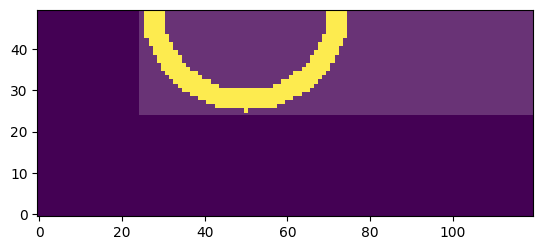

In [26]:
f, ax = plt.subplots(1)
ax.imshow(phi, origin='lower')
grids[0].plot(ax, facecolor=(1,1,1,0.2))

In [27]:
coords = find_grid_division_coord(phi, grids[0])
print(coords)

(34, 34)


In [28]:

new_grids = split_grid_at_coord(grids[0], coords, phi)
new_grids

In [29]:

# subdivided grid one, delete it
del(grids[0])
grids.extend(new_grids)
len(new_grids)

4

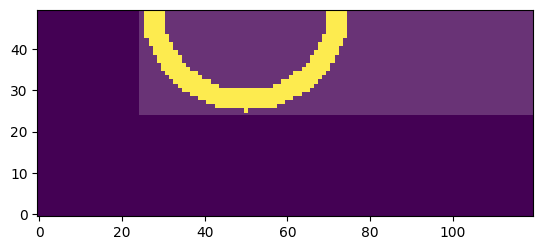

In [30]:
f, ax = plt.subplots(1)
ax.imshow(phi, origin='lower')
grids[0].plot(ax, facecolor=(1,1,1,0.2))
grids[1].plot(ax, facecolor=(1,1,1,0.2))
grids[2].plot(ax, facecolor=(1,1,1,0.2))
grids[3].plot(ax, facecolor=(1,1,1,0.2))

In [31]:
grid_filled_fraction(grids[0].le, grids[0].re, phi)

0.03

In [32]:
if grid_filled_fraction(grids[0].le, grids[0].re, phi) < 0.75: 
    coords = find_grid_division_coord(phi, grids[0])
    new_grids = split_grid_at_coord(grids[0], coords, phi)
    # subdivided grid one, delete it
    del(grids[0])
    grids.extend(new_grids)

In [33]:
len(grids)

4

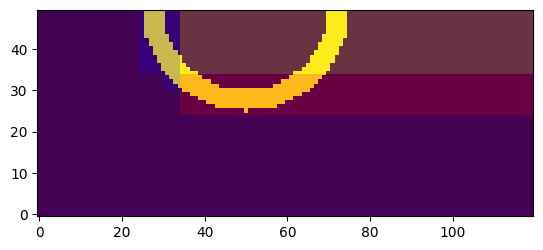

In [34]:
f, ax = plt.subplots(1)
ax.imshow(phi, origin='lower')

grids[0].plot(ax, facecolor=(1,1,0,0.2))
grids[1].plot(ax, facecolor=(1,0,0,0.2))
grids[2].plot(ax, facecolor=(0,0,1,0.2))
grids[3].plot(ax, facecolor=(0,0,1,0.2))

looking pretty good... 

automate/iterate

In [35]:
ideal_grid_fill = 0.9
min_grid_size = 10 # must be >=10 due to lowpass filter requirement
grids = []
grids.append(grid_bounds(np.array([0,0]), np.array([Nx, Ny])))

keepgoing = True
igrid = 0 
n_iters = 0
max_iters = 100
while keepgoing: 
    # print(f"iter {n_iters}")
    fill_frac = grid_filled_fraction(grids[igrid].le, grids[igrid].re, phi)  
    grid_size_checks = tuple(grids[igrid].size >= min_grid_size)
    if fill_frac < ideal_grid_fill and np.all(grid_size_checks): 
        # print(f"checking {igrid}")
        coords = find_grid_division_coord(phi, grids[igrid])
        # print(coords)
        new_grids = split_grid_at_coord(grids[igrid], coords, phi)
        # remove divided grid
        del(grids[igrid])
        # add the new ones to the end         
        grids.extend(new_grids) 
        # print(f"adding {len(new_grids)} grids")
        # do **not** increment igrid, because we deleted one
    else: 
        igrid += 1

    if igrid >= len(grids): 
        # weve reached the end 
        keepgoing = False
    else:
        keepgoing = n_iters < max_iters
        
    n_iters += 1

print(n_iters)
print(len(grids))

18
10


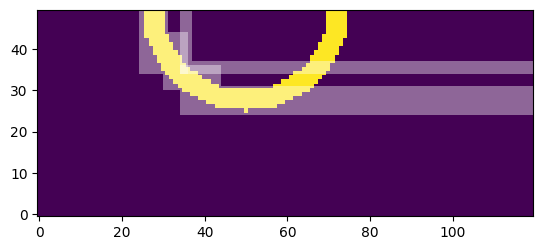

In [36]:
f, ax = plt.subplots(1)
ax.imshow(phi, origin='lower')
for grid in grids:
    grid.plot(ax, facecolor=(1,1,1,0.4))

# using yt_xarray implementation

In [30]:
from yt_xarray.utilities._grid_decomposition import decompose_image_mask
import numpy as np 
import matplotlib.pyplot as plt 

Nx = 120
Ny = 100 

def getphi(ix, iy): 
    # generate an image mask 
    dist_min = 20
    dist_max = 25
    c = 50
    dist = np.sqrt((ix - 30)**2 +(iy - c)**2)
    mask = dist >= dist_min 
    return np.logical_and(mask, dist <= dist_max)
    
ix1d = np.arange(Nx)
iy1d = np.arange(Ny)
ix, iy = np.meshgrid(ix1d, iy1d)

phi = getphi(ix, iy)


grids, niters = decompose_image_mask(phi, max_iters=200)

In [31]:
%%time


grids, niters = decompose_image_mask(phi, max_iters=200)


CPU times: user 32.9 ms, sys: 328 µs, total: 33.3 ms
Wall time: 32.4 ms


48


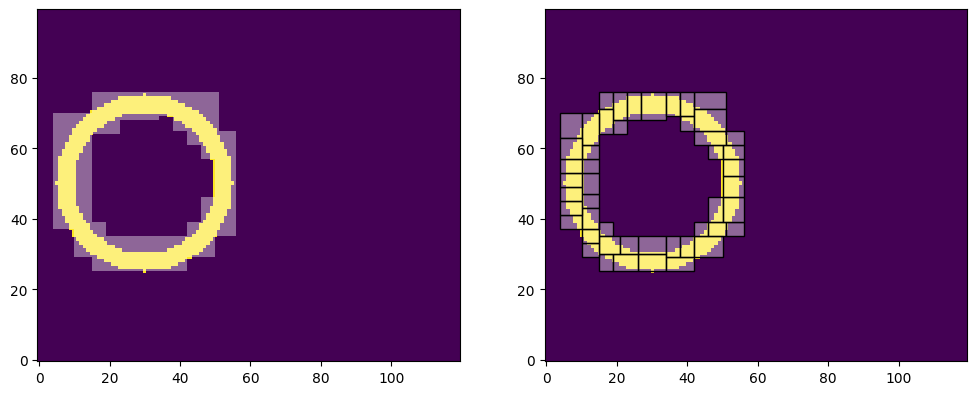

In [32]:

f, axs = plt.subplots(ncols=2,nrows=1, figsize=(12,8))
axs[0].imshow(phi, origin='lower')
axs[1].imshow(phi, origin='lower')
for grid in grids:
    grid.plot(axs[0], facecolor=(1,1,1,0.4))
    grid.plot(axs[1], facecolor=(1,1,1,0.4),edgecolor='k')

print(len(grids))

In [3]:
import numpy as np 
b = np.random.random((5,4,3))

In [4]:
b.shape

(5, 4, 3)

In [5]:
from yt_xarray.utilities._grid_decomposition import signature_array

In [10]:
signature_array(b, 2).shape

(3,)

In [11]:
x = np.linspace(0,1,10)

In [12]:
np.column_stack([x, x, x]).shape

(10, 3)

In [1]:
from yt_xarray.utilities._grid_decomposition import decompose_image_mask
import numpy as np 
import matplotlib.pyplot as plt

Nx = 120
Ny = 100 
Nz = 80

def getphi3d(ix, iy, iz): 
    # generate an image mask 
    dist_min = 20
    dist_max = 25
    c = 50
    dist = np.sqrt((ix - 30)**2 +(iy - c)**2 + (iz - 55)**2)
    mask = dist >= dist_min 
    return np.logical_and(mask, dist <= dist_max)*1.0
    
ix1d = np.arange(Nx)
iy1d = np.arange(Ny)
iz1d = np.arange(Nz)
ix, iy, iz = np.meshgrid(ix1d, iy1d, iz1d)

phi = getphi3d(ix, iy, iz)


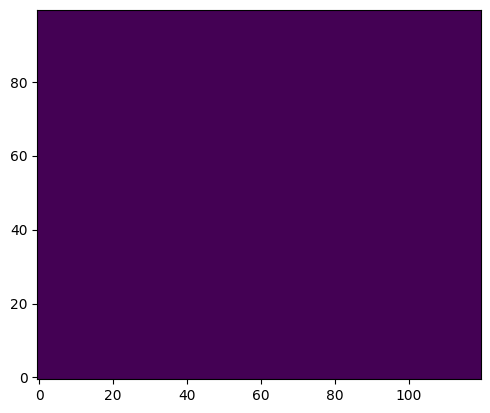

In [2]:
plt.imshow(phi[:,:,10], origin='lower')

In [3]:
phi[0:75, 0:55, 29:80].sum() / phi[0:75, 0:55, 29:80].size

0.1516007130124777

In [18]:

grids, n_iters = decompose_image_mask(phi, max_iters=200, min_grid_size=30)
len(grids), n_iters

(98, 158)

In [21]:
grids[0].le, grids[0].re, grids[0].size

((47, 55, 52), (75, 59, 80), array([28,  4, 28]))

In [20]:
%%time 
grids, n_iters = decompose_image_mask(phi, max_iters=200, min_grid_size=30)

CPU times: user 59.9 ms, sys: 0 ns, total: 59.9 ms
Wall time: 58.9 ms


In [2]:
from yt_xarray.utilities._grid_decomposition import decompose_image_mask, _get_yt_ds
import numpy as np 
import matplotlib.pyplot as plt

Nx = 120
Ny = 100 
Nz = 80

def getphi3d(ix, iy, iz): 
    # generate an image mask 
    dist_min = 20
    dist_max = 25
    c = 50
    dist = np.sqrt((ix - 30)**2 +(iy - c)**2 + (iz - 55)**2)
    mask = dist >= dist_min 
    return np.logical_and(mask, dist <= dist_max)*1.0
    
ix1d = np.arange(Nx)
iy1d = np.arange(Ny)
iz1d = np.arange(Nz)
ix, iy, iz = np.meshgrid(ix1d, iy1d, iz1d)

phi = getphi3d(ix, iy, iz)


In [13]:
bbox = np.array([[0,1],[0,1],[0,1]])
ds = _get_yt_ds(phi, bbox, min_grid_size=20, refine_by=2)

yt : [INFO     ] 2024-02-26 16:24:34,895 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-02-26 16:24:34,895 Parameters: domain_dimensions         = [100 120  80]
yt : [INFO     ] 2024-02-26 16:24:34,896 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-02-26 16:24:34,896 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-02-26 16:24:34,897 Parameters: cosmological_simulation   = 0


In [14]:
ds.field_list

[('stream', 'density')]

yt : [INFO     ] 2024-02-26 16:24:35,933 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-02-26 16:24:35,934 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-02-26 16:24:35,936 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-02-26 16:24:35,936 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-02-26 16:24:35,938 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



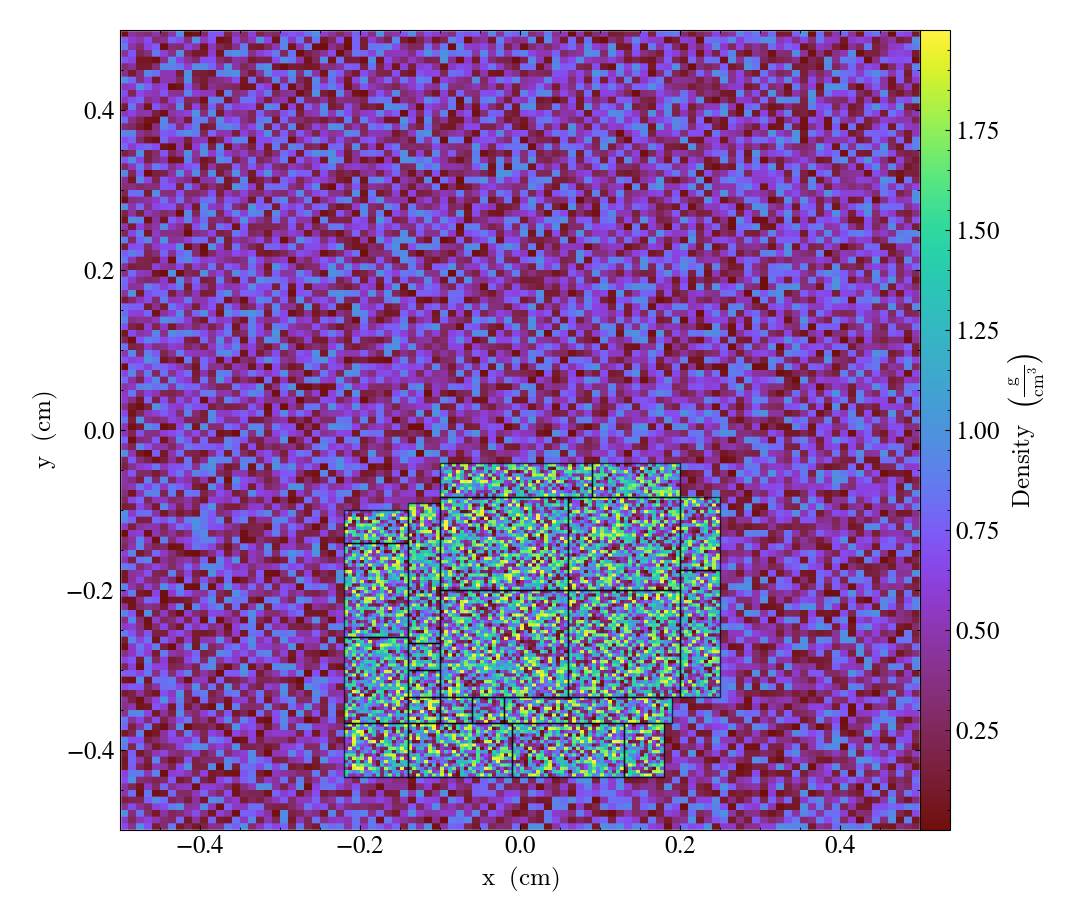

In [15]:
import yt
slc = yt.SlicePlot(ds, 'z', 'density')
slc.annotate_grids()
slc.set_log('density', False)

yt : [INFO     ] 2024-02-26 17:43:51,354 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-02-26 17:43:51,354 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-02-26 17:43:51,355 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-02-26 17:43:51,355 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-02-26 17:43:51,356 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-02-26 17:43:51,549 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-02-26 17:43:51,550 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-02-26 17:43:51,552 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-02-26 17:43:51,552 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-02-26 17:43:51,557 Making a fixed resolution buffer of (('stream', 'density')) 800 by 800



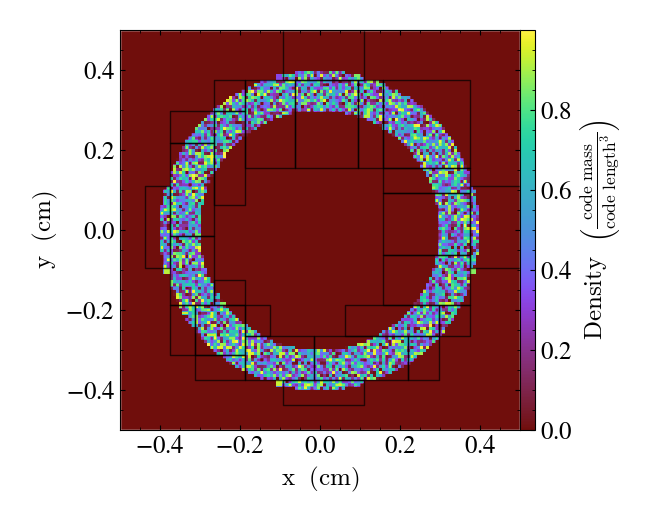

In [1]:
from yt_xarray.utilities._grid_decomposition import decompose_image_mask, _get_yt_ds
import numpy as np 
import yt

def _image_mask(x, y, z):
    # a boolean mask indicating where there is data.
    c = (0.5,)*3
    dist_min = 0.3
    dist_max = 0.4
    dist = np.sqrt((x - c[0])**2 + (y-c[1])**2 + (z-c[1])**2)
    mask = dist >= dist_min 
    mask = np.logical_and(mask, dist <= dist_max)
    return mask
    
def image_callable(grid, field_name):
    x = grid['index', 'x'].d
    y = grid['index', 'y'].d
    z = grid['index', 'z'].d
    
    mask = _image_mask(x, y, z)
    if field_name[1] == 'image':
        return mask * 1.0 
    elif field_name[1] == 'density':
        data = np.random.random(mask.shape)
        data[~mask] = 0. # np.nan
        return data
    

Nx = 64
Ny = 64 
Nz = 64    
ix1d = np.linspace(0, 1, Nx)
iy1d = np.linspace(0, 1, Ny)
iz1d = np.linspace(0, 1, Nz)
x, y, z = np.meshgrid(ix1d, iy1d, iz1d)
image_mask = _image_mask(x, y, z)

bbox = np.array([[0,1],[0,1],[0,1]])
data_callables = {
    'image': image_callable, 
    'density': image_callable
}

ds = _get_yt_ds(image_mask, data_callables, bbox, min_grid_size=16, refine_by=2, max_iters=400)

slc = yt.SlicePlot(ds, 'z', ('stream', 'density'), window_size=(4,4))
slc.annotate_grids()
slc.set_log(('stream', 'density'), False)